In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import models, transforms
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm
import os
from google.colab import drive
from torch.utils.data import TensorDataset, DataLoader # Import TensorDataset and DataLoader
import time
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
drive.mount('/content/drive',force_remount=True)
wd = "/content/drive/MyDrive/project"
os.chdir(wd)

Mounted at /content/drive


In [ ]:
# Load data
train_images, train_labels = torch.load('train_preprocessed.pt')
val_images, val_labels = torch.load('val_preprocessed.pt')
test_images, test_labels = torch.load('test_preprocessed.pt')

In [ ]:
# Create Dataset objects
train_dataset = TensorDataset(train_images, train_labels)
val_dataset = TensorDataset(val_images, val_labels)
test_dataset = TensorDataset(test_images, test_labels)

In [ ]:
# Model
#model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
#model = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
#model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V2)
#model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1)
#model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
model = models.regnet_y_3_2gf(weights = models.RegNet_Y_3_2GF_Weights.IMAGENET1K_V2)
num_ftrs = model.fc.in_features
num_classes = len(torch.unique(train_labels))
# Fine tuning layer
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout layer
    nn.Linear(512, num_classes)
)

#num_ftrs = model.classifier[0].in_features  # Get input features of the first layer in classifier

"""model.classifier = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),  # Dropout layer
    nn.Linear(512, num_classes)
)"""
model.fc = nn.Linear(num_ftrs, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 72, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(72, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=3, bias=False)
            

In [ ]:
# Dataloaders

batch_size = 64  # or whatever batch size you prefer

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Set up optimizer and loss function
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)#, momentum=0.9, weight_decay=1e-4)
optimizer = optim.AdamW(model.fc.parameters(), lr=0.01, weight_decay=0.001)

In [ ]:
# Freeze all layers except last
for param in model.parameters():
  param.requires_grad = False
for param in model.fc.parameters():
  param.requires_grad = True

"""# Freeze all layers except the classifier layer
for param in model.features.parameters():  # Freeze only the features part
  param.requires_grad = False

# Unfreeze the classifier layer
for param in model.classifier.parameters():
  param.requires_grad = True"""

'# Freeze all layers except the classifier layer\nfor param in model.features.parameters():  # Freeze only the features part\n  param.requires_grad = False\n\n# Unfreeze the classifier layer\nfor param in model.classifier.parameters():\n  param.requires_grad = True'

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR

start = time.time()
num_epochs = 100  # Adjust as needed

# Lists to store training and validation metrics


scheduler = CosineAnnealingLR(optimizer, T_max=100)  # T_max = number of epochs
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01)


for epoch in range(num_epochs):
    # Training loop
    model.train()
    #print(f'Epoch {epoch+1}/{num_epochs}')
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation loop with detailed metrics
    model.eval()
    running_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}] - '
          f'Train Loss: {epoch_loss:.4f} - '
          f'Val Loss: {epoch_val_loss:.4f} - '
          f'Val Accuracy: {val_accuracy:.2f}%'
          f'Epoch time:', time.time() - start)


    # Update learning rate scheduler
    scheduler.step()

Epoch [1/100] - Train Loss: 1.1754 - Val Loss: 0.6758 - Val Accuracy: 75.37%Epoch time: 3.1301140785217285
Epoch [2/100] - Train Loss: 0.6021 - Val Loss: 0.6383 - Val Accuracy: 77.89%Epoch time: 6.42879843711853
Epoch [3/100] - Train Loss: 0.4514 - Val Loss: 0.5518 - Val Accuracy: 81.47%Epoch time: 9.669015407562256
Epoch [4/100] - Train Loss: 0.3812 - Val Loss: 0.6426 - Val Accuracy: 79.16%Epoch time: 12.91169810295105
Epoch [5/100] - Train Loss: 0.3003 - Val Loss: 0.6165 - Val Accuracy: 78.32%Epoch time: 16.18645691871643
Epoch [6/100] - Train Loss: 0.2684 - Val Loss: 0.6035 - Val Accuracy: 79.58%Epoch time: 19.463571548461914
Epoch [7/100] - Train Loss: 0.2615 - Val Loss: 0.5913 - Val Accuracy: 81.68%Epoch time: 22.713256120681763
Epoch [8/100] - Train Loss: 0.1979 - Val Loss: 0.6311 - Val Accuracy: 80.84%Epoch time: 25.977439880371094
Epoch [9/100] - Train Loss: 0.1736 - Val Loss: 0.6382 - Val Accuracy: 79.16%Epoch time: 29.29257893562317
Epoch [10/100] - Train Loss: 0.1483 - Val L

In [ ]:
torch.save(model.state_dict(), 'RegNet_Y_3_2GF_model.pth')


In [ ]:
train_losses = train_losses[100:200]
val_losses = val_losses[100:200]
val_accuracies = val_accuracies[100:200]

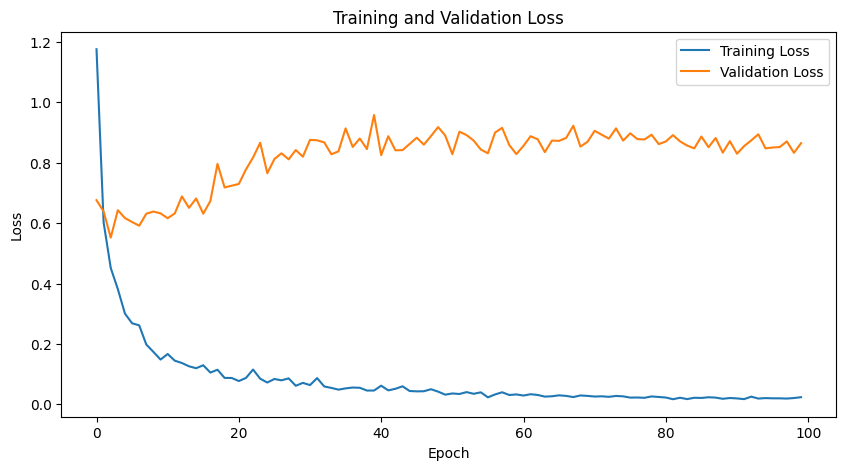

In [ ]:

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

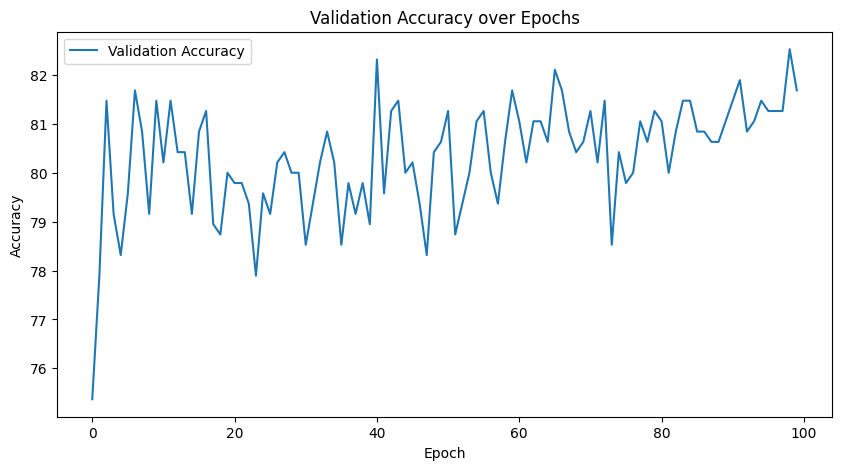

In [ ]:
# prompt: Write code to make a chart of the training and validation accuracies over epochs

plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()
plt.show()


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 80.46%


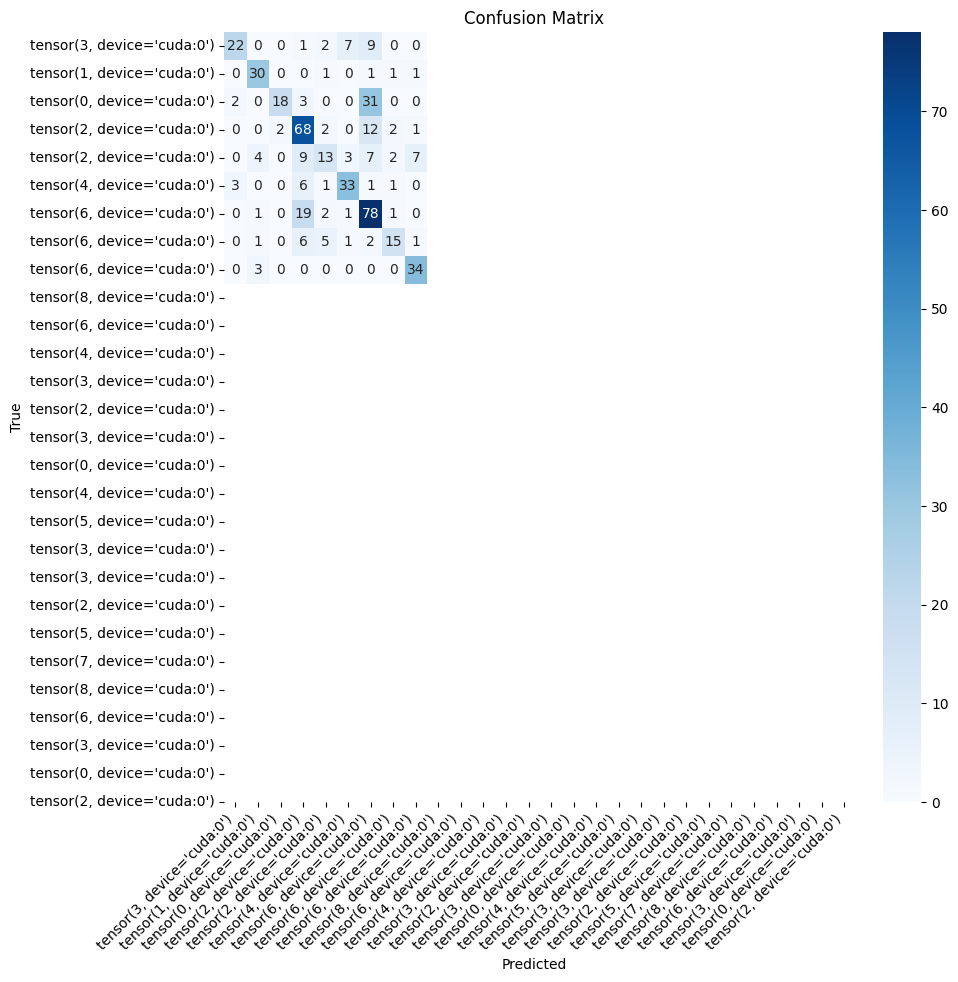

In [ ]:

labels = {0: 'Cardboard', 1: 'Food Organics', 2: 'Glass', 3: 'Metal', 4: 'Miscellaneous Trash', 5: 'Paper', 6: 'Plastic', 7: 'Textile Trash', 8: 'Vegetation'}

all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate and plot confusion matrix with labels
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[labels[i] for i in range(len(labels))],
            yticklabels=[labels[i] for i in range(len(labels))])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


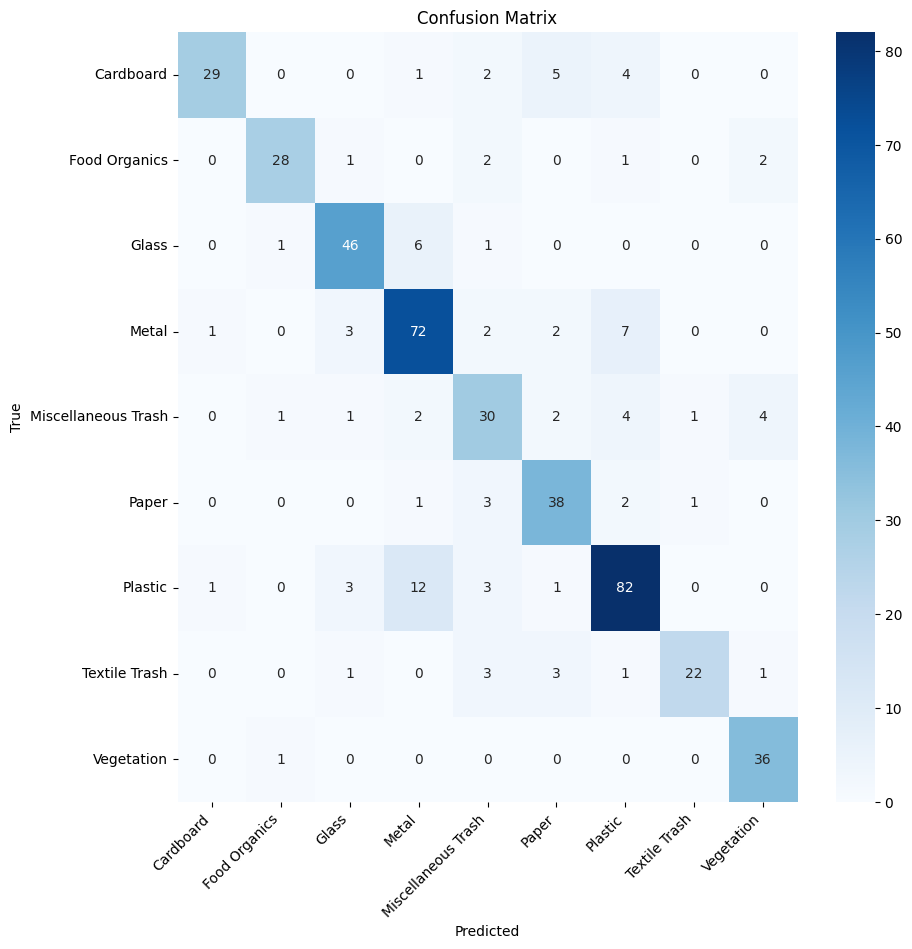

In [ ]:
labels_dict = {
    0: 'Cardboard', 1: 'Food Organics', 2: 'Glass', 3: 'Metal',
    4: 'Miscellaneous Trash', 5: 'Paper', 6: 'Plastic',
    7: 'Textile Trash', 8: 'Vegetation'
}

all_predictions = []
all_targets = []

with torch.no_grad():
    for inputs, targets in test_loader:  # 🔁 renamed here
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

# Plot confusion matrix
cm = confusion_matrix(all_targets, all_predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[labels_dict[i] for i in range(len(labels_dict))],
            yticklabels=[labels_dict[i] for i in range(len(labels_dict))])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()